<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/models/KNN_gridsearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [146]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [147]:
%matplotlib inline

# Download dataset

In [5]:
%%capture
! wget https://raw.githubusercontent.com/Dimildizio/DS_course/main/Unsupervised/data/forest_dataset.csv

# Load dataset to dataframe

In [124]:
all_data = pd.read_csv('forest_dataset.csv')
all_data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2683,333,35,30,26,2743,121,173,179,6572,...,0,0,0,0,0,0,0,0,0,2
1,2915,90,8,216,11,4433,232,228,129,4019,...,0,0,0,0,0,0,0,0,0,1
2,2941,162,7,698,76,2783,227,242,148,1784,...,0,0,0,0,0,0,0,0,0,2
3,3096,60,17,170,3,3303,231,202,99,5370,...,0,0,0,0,0,0,0,0,0,1
4,2999,66,8,488,37,1532,228,225,131,2290,...,0,0,0,0,0,0,0,0,0,2


# Get Xs and ys

In [125]:
labels = all_data[all_data.columns[-1]].values
feature_matrix = all_data[all_data.columns[:-1]].values

# Create standard scaler

In [109]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(all_data)

# Create train test splitter

In [115]:
def split(X, y, scaler = False):
  X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.2, random_state=42)
  if scaler:
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
  return X_train, X_test, y_train, y_test

# Create visualizer

In [164]:
def visual(model, X_test, y_test):
  pred_prob = model.predict_proba(X_test)
  unique, freq = np.unique(y_test, return_counts=True)
  freq = list(map(lambda x: x / len(y_test), freq))
  print([np.round(x, 2) for x in freq])

  pred_freq = pred_prob.mean(axis=0)
  plt.figure(figsize=(10, 8))
  plt.bar(range(1, 8), pred_freq, width=0.4, align="edge", label='prediction')
  plt.bar(range(1, 8), freq, width=-0.4, align="edge", label='real')
  plt.ylim(0, 0.54)

  for i, (real, pred) in enumerate(zip(freq, pred_freq)):
    plt.text(i + 1, real + 0.01, f'{real:.2f}', ha='center', va='bottom', fontsize=10, color='blue')
    plt.text(i + 1, pred + 0.01, f'{pred:.2f}', ha='center', va='bottom', fontsize=10, color='orange')

  plt.legend()
  plt.show()

# Create trainer and processing function

In [167]:
def get_result(model, df, scale = False):
  X = df.drop(df.columns[-1], axis=1)
  y = df[df.columns[-1]]
  X_train, X_test, y_train, y_test = split(X, y, scale)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  print(accuracy_score(y_pred, y_test))
  visual(model, X_test, y_test)
  return model

# Flow

## Split data

In [116]:
X_train, X_test, y_train, y_test = split(feature_matrix, labels)

## Train logistic regression

In [93]:
clf = LogisticRegression(C=2, penalty='l1', max_iter=5000, solver='saga')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_pred, y_test))

0.721


## Use gridsearch

In [94]:
param_grid = {
    'C': np.arange(1, 5),
    'penalty': ['l1', 'l2'],
}
clf = LogisticRegression(solver='saga')
search = GridSearchCV(clf, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy')
search.fit(feature_matrix, labels)
print(search.best_params_)
print(accuracy_score(labels, search.best_estimator_.predict(feature_matrix)))

{'C': 2, 'penalty': 'l1'}
0.642


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


## Get knn result

In [128]:
knn = KNeighborsClassifier()
get_result(knn, all_data)

0.7365


## Gridsearch again for knn

In [126]:
gs_knn = KNeighborsClassifier()
params = {
    'metric':['euclidean','manhattan'],
    'weights':['uniform', 'distance'],
    'n_neighbors':list(range(1,11))
}

clf_grid = GridSearchCV(gs_knn, params, cv=5, scoring='accuracy', n_jobs=-1)
clf_grid.fit(feature_matrix, labels)
best_params = clf_grid.best_params_
print(best_params)

{'metric': 'manhattan', 'n_neighbors': 4, 'weights': 'distance'}


## Get result

0.785
[0.37, 0.49, 0.06, 0.01, 0.02, 0.03, 0.04]


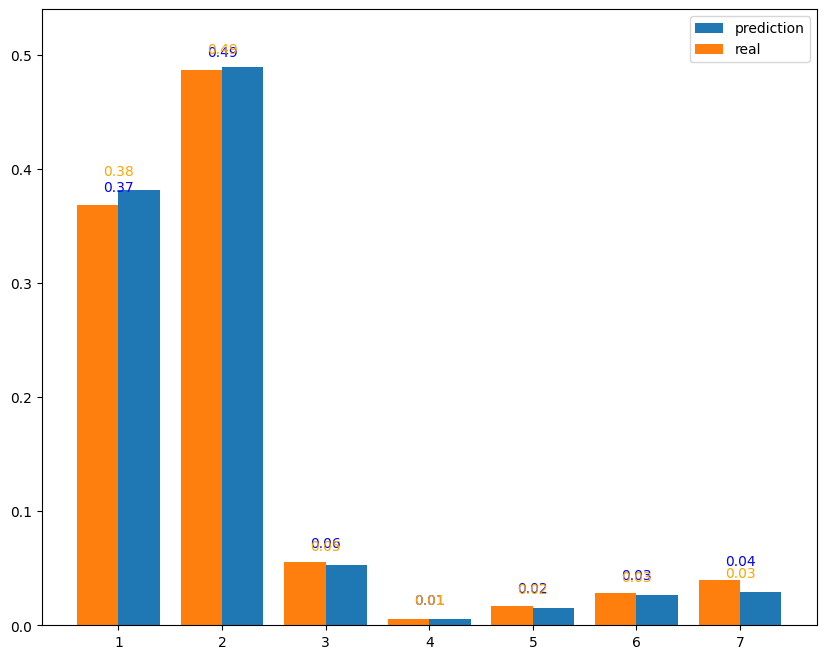

In [166]:
best_knn = KNeighborsClassifier(metric='manhattan', n_neighbors=4, weights='distance')
result1 = get_result(best_knn, all_data)